In [35]:
__author__ = 'bptripp'

# This is a rough draft of a way to select actions to stack, based on effects
# and other contextual information. The basic idea is that there are lots of
# possibilities and we need something like an SQL WHERE clause for finding an
# action that is a good match for the current intention and the context
# (which is largely the location, e.g. kitchen).
#
# There are a couple of possible mappings that seem reasonable:
#   1) goal+location->things then things+intent->action
#   2) location+intent->action
#
# Below is a network that implements #1. I'm not very handy with SPA, so the
# scaling is all wrong (I've added a mess of constants to make it a little better)
# and the WTA competition doesn't work. Also, strangely, the noise is highly
# correlated across associative memory outputs.

import numpy as np
import matplotlib.pyplot as plt
import nengo
from nengo import spa
%matplotlib inline 
  
D=256
    
base_items= ['LOCATION','GOAL','GARAGE','HOLE_MADE','STAFF_LOUNGE','WATER_BOILED','KITCHEN','HOME_DEPOT',
             'KETTLE_UNPLUGGED','KETTLE_PLUGGED_IN','WATER_IN_KETTLE','KETTLE_UNDER_TAP','EFFECTS','OBJECT']

base_vocab = spa.Vocabulary(D)

for item in base_items:
    base_vocab.parse(item)

obj_vocab = base_vocab.create_subset(base_items)
obj_id_vocab = base_vocab.create_subset(base_items)
act_id_vocab = base_vocab.create_subset(base_items)
act_vocab = base_vocab.create_subset(base_items)


vec = base_vocab.parse('LOCATION*KITCHEN+LOCATION*STAFF_LOUNGE+LOCATION*HOME_DEPOT')+1*(base_vocab.parse('GOAL*WATER_BOILED'))
vec.normalize()
obj_vocab.add('KETTLE', vec)

vec = base_vocab.parse('LOCATION*KITCHEN+LOCATION*STAFF_LOUNGE')+1*(base_vocab.parse('GOAL*WATER_BOILED'))
vec.normalize()
obj_vocab.add('TAP', vec)

vec = base_vocab.parse('LOCATION*GARAGE+LOCATION*HOME_DEPOT')+1*(base_vocab.parse('GOAL*HOLE_MADE'))
vec.normalize()
obj_vocab.add('DRILL', vec)


obj_id_vocab.parse('KETTLE')
obj_id_vocab.parse('TAP')
obj_id_vocab.parse('DRILL')


c = 1
vec = base_vocab['OBJECT'] * obj_id_vocab['KETTLE'] + c * (base_vocab['EFFECTS'] * base_vocab['WATER_BOILED'])
vec.normalize()
act_vocab.add('BOIL_KETTLE', vec)

vec = base_vocab['OBJECT'] * obj_id_vocab['KETTLE'] + c * (base_vocab['EFFECTS'] * base_vocab['KETTLE_PLUGGED_IN'])
vec.normalize()
act_vocab.add('PLUG_IN_KETTLE', vec)

vec = base_vocab['OBJECT'] * obj_id_vocab['KETTLE'] + c * (base_vocab['EFFECTS'] * base_vocab['KETTLE_UNPLUGGED'])
vec.normalize()
act_vocab.add('UNPLUG_KETTLE', vec)

vec = base_vocab['OBJECT'] * obj_id_vocab['TAP'] + c * (base_vocab['EFFECTS'] * base_vocab['WATER_IN_KETTLE'])
vec.normalize()
act_vocab.add('FILL_KETTLE_FROM_TAP', vec)

vec = base_vocab['OBJECT'] * obj_id_vocab['KETTLE'] + c * (base_vocab['EFFECTS'] * base_vocab['KETTLE_UNDER_TAP'])
vec.normalize()
act_vocab.add('PUT_KETTLE_UNDER_TAP', vec)


act_id_vocab.parse('BOIL_KETTLE')
act_id_vocab.parse('PLUG_IN_KETTLE')
act_id_vocab.parse('UNPLUG_KETTLE')
act_id_vocab.parse('FILL_KETTLE_FROM_TAP')
act_id_vocab.parse('PUT_KETTLE_UNDER_TAP')

test = act_id_vocab.create_subset(['BOIL_KETTLE','UNPLUG_KETTLE','PLUG_IN_KETTLE','PUT_KETTLE_UNDER_TAP','FILL_KETTLE_FROM_TAP'])

for item in ['BOIL_KETTLE','UNPLUG_KETTLE','PLUG_IN_KETTLE','PUT_KETTLE_UNDER_TAP','FILL_KETTLE_FROM_TAP']:
    print item
    print act_vocab.dot(act_vocab[item])
    print ''


BOIL_KETTLE
[-0.03584323  0.02068633  0.11106319 -0.03761719  0.09267261  0.05136262
 -0.00117039 -0.06972704  0.0718031   0.0354307  -0.03716311  0.03504978
  0.07195721  0.03742146  1.          0.57053589  0.42909087  0.02056765
  0.59047177]

UNPLUG_KETTLE
[-0.06853141  0.04552718  0.04295117  0.03184934  0.03112906 -0.06649868
 -0.03291511 -0.14669283 -0.06318677  0.05437619  0.07420525  0.02864609
  0.18059741 -0.06566245  0.42909087  0.49482571  1.         -0.05794382
  0.4612076 ]

PLUG_IN_KETTLE
[-0.00282441  0.04589576  0.00887599 -0.04547191  0.07701598 -0.01660246
 -0.01750274 -0.10360349  0.10794177  0.04465842  0.05710558  0.09487093
  0.10047819 -0.03878677  0.57053589  1.          0.49482571  0.0467555
  0.56798763]

PUT_KETTLE_UNDER_TAP
[-0.08825974  0.00923204  0.04377638 -0.00912162  0.04237372 -0.00653891
 -0.10145967 -0.10192646  0.03457241 -0.0115888  -0.03206296  0.04727117
  0.07505359 -0.07117931  0.59047177  0.56798763  0.4612076   0.02713287
  1.        ]

FIL

Simulation finished in 0:00:07.                                                 


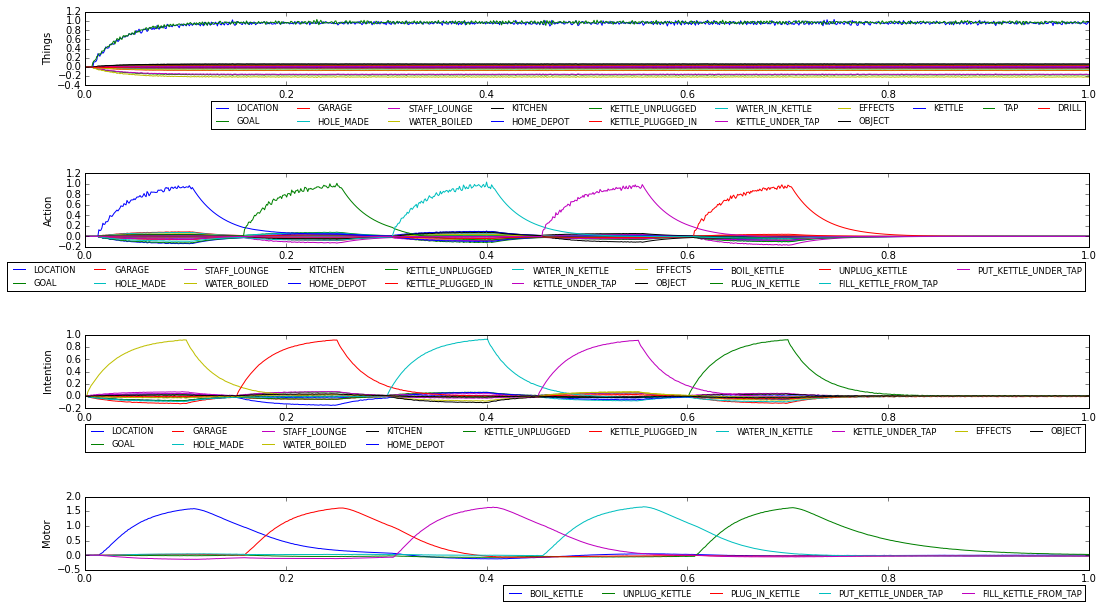

In [36]:
model = spa.SPA()
with model:
    
    model.goal = spa.State(D, vocab=base_vocab)
    model.intention = spa.State(D, vocab=base_vocab)
    model.location = spa.State(D, vocab=base_vocab)

    model.things = spa.AssociativeMemory(input_vocab=obj_vocab, output_vocab=obj_id_vocab,
                                         input_keys=['KETTLE','TAP','DRILL'], output_keys=['KETTLE','TAP','DRILL'],
                                         wta_output=False, threshold=.5)
    
    model.action = spa.AssociativeMemory(input_vocab=act_vocab, output_vocab=act_id_vocab, 
                                         input_keys=['BOIL_KETTLE','PLUG_IN_KETTLE','UNPLUG_KETTLE','FILL_KETTLE_FROM_TAP','PUT_KETTLE_UNDER_TAP'],
                                         output_keys=['BOIL_KETTLE','PLUG_IN_KETTLE','UNPLUG_KETTLE','FILL_KETTLE_FROM_TAP','PUT_KETTLE_UNDER_TAP'],
                                         wta_output=True, threshold=.9)
  
    model.motor = spa.Memory(D, vocab=test, tau=0.05)
    
    nengo.Connection(model.location.output, model.things.input, transform=base_vocab['LOCATION'].get_convolution_matrix())
    nengo.Connection(model.goal.output, model.things.input, transform=base_vocab['GOAL'].get_convolution_matrix())
    
    nengo.Connection(model.things.output, model.action.input, transform=base_vocab['OBJECT'].get_convolution_matrix())
    nengo.Connection(model.intention.output, model.action.input, transform=base_vocab['EFFECTS'].get_convolution_matrix())
    
    nengo.Connection(model.action.output, model.motor.state.input)
    
    def set_goal(t):
        return 'WATER_BOILED'
    model.goal_inp = spa.Input(goal=set_goal)

    def set_location(t):
        if t < 1: return 'KITCHEN'
        else: return 'GARAGE'
    model.loc_inp = spa.Input(location=set_location)

    def set_intention(t):
        if 0 < t <= 0.1: return 'WATER_BOILED'
        if 0.15 < t <= 0.25: return 'KETTLE_PLUGGED_IN'
        if 0.3 < t <= 0.4: return 'WATER_IN_KETTLE'
        if 0.45 < t <= 0.55: return 'KETTLE_UNDER_TAP'
        if 0.6 < t <= 0.7: return 'KETTLE_UNPLUGGED'
        else: return '0'
    model.intention_inp = spa.Input(intention=set_intention)

    things_probe = nengo.Probe(model.things.output, synapse=0.03)
    action_probe = nengo.Probe(model.action.output, synapse=0.03)
    intention_probe = nengo.Probe(model.intention.output, synapse=0.03)
    motor_probe = nengo.Probe(model.motor.state.output, synapse=0.03)
    
def plot_results(sim):
    fig = plt.figure(figsize=(18,10))

    p1 = fig.add_subplot(4,1,1)
    p1.plot(sim.trange(), model.similarity(sim.data, things_probe))
    p1.legend(model.get_output_vocab('things').keys, fontsize='small', bbox_to_anchor=(1, -0.15), ncol=10)
    p1.set_ylabel('Things')

    p2 = fig.add_subplot(4,1,2)
    p2.plot(sim.trange(), model.similarity(sim.data, action_probe))
    p2.legend(model.get_output_vocab('action').keys, fontsize='small', bbox_to_anchor=(1, -0.15), ncol=10)
    p2.set_ylabel('Action')

    p3 = fig.add_subplot(4,1,3)
    p3.plot(sim.trange(), model.similarity(sim.data, intention_probe))
    p3.legend(model.get_output_vocab('intention').keys, fontsize='small', bbox_to_anchor=(1, -0.15), ncol=10)
    p3.set_ylabel('Intention')
    
    p4 = fig.add_subplot(4,1,4)
    p4.plot(sim.trange(), model.similarity(sim.data, motor_probe))
    p4.legend(model.get_output_vocab('motor').keys, fontsize='small', bbox_to_anchor=(1, -0.15), ncol=10)
    p4.set_ylabel('Motor')

    plt.subplots_adjust(hspace=1.2)
    plt.show()

sim = nengo.Simulator(model)
sim.reset()
sim.run(1)
plot_results(sim)

